## Customer Segmentation using RFM analysis

RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments. It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy. RFM filters customers into various groups for the purpose of better service. It helps managers to identify potential customers to do more profitable business. There is a segment of customer who is the big spender but what if they purchased only once or how recently they purchased? Do they often purchase our product? Also, It helps managers to run an effective promotional campaign for personalized service.

- Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
- Frequency (F): Who has purchased frequently? It means the total number of purchases. ( high frequency)
- Monetary Value(M): Who have high purchase amount? It means the total money customer spent (high monetary value)

Here, Each of the three variables(Recency, Frequency, and Monetary) consists of four equal groups, which creates 64 (4x4x4) different customer segments.

Steps of RFM(Recency, Frequency, Monetary):

- Calculate the Recency, Frequency, Monetary values for each customer.
- Add segment bin values to RFM table using quartile.
- Sort the customer RFM score in ascending order.

In [3]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from pandas import ExcelWriter
from pandas import ExcelFile

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import seaborn as sns # for plotting graphs
import datetime as dt

print('Libraries imported.')

Libraries imported.


## Customer Dataset
Let's first load the required HR dataset using the pandas read CSV function. You can download the data from this link.

In [ ]:
#url="https://archive.ics.uci.edu/ml/machine-learning-databases/00352"
#df = pd.read_excel('File.xlsx', sheetname='Sheet1')
file = '/resources/data/Online_Retail.xlsx'
data=pd.read_excel(file)
data.head()

In [ ]:
data.tail()

In [ ]:
data1= data[pd.notnull(data['CustomerID'])]
data1.head()

### Now we check for duplicates

In [ ]:
data2 = data1[['Country','CustomerID']]
data2.head(20)

In [ ]:
#data1.duplicated()
data1[['Country','CustomerID']].duplicated()

## lets clean the data by dropping duplicates

In [ ]:
filtered_data=data1[['Country','CustomerID']].drop_duplicates()
filtered_data.head()

### Lets look at some visualization


In [ ]:
#Top ten country's customer
filtered_data.Country.value_counts()[:20].plot(kind='bar')

### In the given dataset, it can observe that most of the customers are from the "United Kingdom". 
### So, let's filter data for United Kingdom customer.

In [ ]:
uk_data=data1[data1.Country=='United Kingdom']
uk_data.head()

In [ ]:
uk_data.shape
print('The data has', uk_data.shape, 'rows and columns respectively.')

### Describe
The describe() function in pandas is convenient in getting various summary statistics. This function returns the count, mean, standard deviation, minimum and maximum values and the quantiles of the data.

In [ ]:
uk_data.describe()

From the description above, we can observe some of the customers have ordered in a negative quantity, which is not possible. So, you need to filter Quantity greater than zero

In [ ]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.head()

In [ ]:
uk_data.info()

In [ ]:
uk_data.describe()

### Let's filter required Columns

Here, you can filter the necessary columns for RFM analysis. We only need five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice. CustomerId will uniquely define your customers, InvoiceDate help you calculate recency of purchase, InvoiceNo helps you to count the number of time transaction performed(frequency). Quantity purchased in each transaction and UnitPrice of each unit purchased by the customer will help to calculate the total purchased amount.

In [ ]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

### We calculate a toral price and add it to a new fiels 'TotalPrice'

In [31]:
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [32]:
uk_data['InvoiceDate'].min(),uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [33]:
PRESENT = dt.datetime(2011,12,10)
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [34]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


## RFM Analysis
Let's perform following opertaions:

- For Recency, Calculate the number of days between present date and date of last purchase each customer.
- For Frequency, Calculate the number of orders for each customer.
- For Monetary, Calculate sum of purchase price for each customer.

In [35]:
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


### Change the name of columns

In [36]:
rfm.columns=['monetary','frequency','recency']
rfm.head()

,monetary,frequency,recency
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


In [37]:
rfm['recency'] = rfm['recency'].astype(int)

In [38]:
rfm.head()

,monetary,frequency,recency
CustomerID,,,
12346.0,325,1,77183
12747.0,2,103,4196
12748.0,0,4596,33719
12749.0,3,199,4090
12820.0,3,59,942


### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

qcut() is Quantile-based discretization function. qcut bins the data based on sample quantiles. For example, 1000 values for 4 quantiles would produce a categorical object indicating quantile membership for each customer.

In [39]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183,4,4,1
12747.0,2,103,4196,4,1,4
12748.0,0,4596,33719,4,1,4
12749.0,3,199,4090,4,1,4
12820.0,3,59,942,3,2,4


### RFM Result Interpretation
Combine all three quartiles(r_quartile,f_quartile,m_quartile) in a single column, this rank will help you to segment the customers group well.

In [64]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183,4,4,1,441
12747.0,2,103,4196,4,1,4,414
12748.0,0,4596,33719,4,1,4,414
12749.0,3,199,4090,4,1,4,414
12820.0,3,59,942,3,2,4,324


### Let's sort the datafram by RFM_Score

In [65]:
rfm_sort=rfm.sort_values(by='RFM_Score')
rfm_sort.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
17254.0,4,112,272,1,1,4,114
17860.0,368,58,252,1,2,1,121
13568.0,173,44,192,1,2,1,121
17968.0,373,85,277,1,2,1,121
18212.0,326,43,248,1,2,1,121


### Let's filter out top/best customers

In [66]:
best_customers = rfm[rfm['RFM_Score']=='114'].sort_values('monetary', ascending=False)
best_customers.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
17254.0,4,112,272,1,1,4,114


In [67]:
print('The data has', best_customers.shape, 'rows and columns respectively.')

The data has (1, 7) rows and columns respectively.


##  Using k-means for Customer Segmentation

Let's import some important libraries and normalize the dataset. Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.

In [68]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

X = rfm.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [81]:
num_clusters = 4

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [82]:
print(k_means.cluster_centers_)  

[[3.58688889e+02 9.68862222e+03 4.00000000e+00 1.21666667e+00
  3.63333333e+00 4.15800000e+02]
 [7.02683715e+01 1.00327510e+03 2.41453567e+00 2.58734859e+00
  2.44764468e+00 2.69774697e+02]
 [2.57000000e+02 2.07559667e+05 4.00000000e+00 2.00000000e+00
  4.00000000e+00 4.24000000e+02]
 [1.21578261e+03 5.27256087e+04 4.00000000e+00 1.47826087e+00
  3.52173913e+00 4.18304348e+02]]


In [83]:
labels = k_means.labels_

print(k_means.labels_)  

[3 1 3 ... 1 1 1]


In [84]:
rfm["Labels"] = labels
rfm.head(5)

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Score,Labels
CustomerID,,,,,,,,
12346.0,325,1,77183,4,4,1,441,3
12747.0,2,103,4196,4,1,4,414,1
12748.0,0,4596,33719,4,1,4,414,3
12749.0,3,199,4090,4,1,4,414,1
12820.0,3,59,942,3,2,4,324,1


In [85]:
#rfm.groupby('Labels').mean().astype(int)

Text(0,0.5,'Regency')

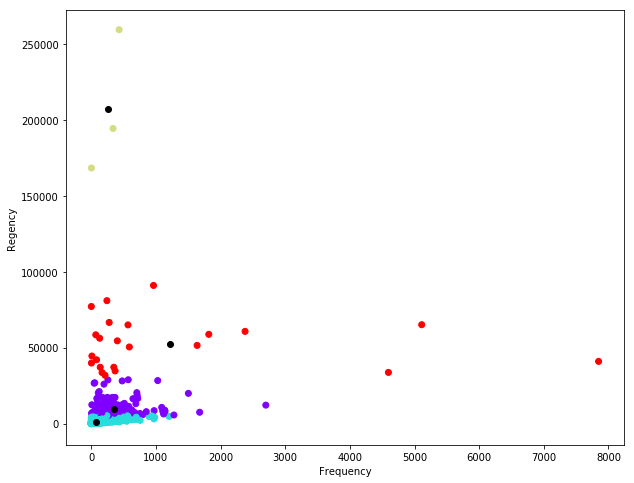

In [86]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=k_means.labels_, cmap='rainbow')  
plt.scatter(k_means.cluster_centers_[:,0] ,k_means.cluster_centers_[:,1], color='black') 
plt.xlabel('Frequency', fontsize=10)
plt.ylabel('Regency', fontsize=10)